File name: model_experiments

Description: This file experiments with different ML model types to find which is most accurate with the data.

In [21]:
import spacy 
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import pickle

data = pd.read_csv('data/intentions.csv')

#load english language model in SpaCy 
nlp = spacy.load("en_core_web_sm")
vectoriser = CountVectorizer()

vectoriser.fit(data['input'].tolist()) # Fit vectoriser to training data
#vocabulary

with open('vectoriser.pkl', 'wb') as f: 
    pickle.dump(vectoriser, f)

def preprocess_text(text):
    doc = nlp(text)
    processed_tokens = []
    for token in doc: 
        if (not token.is_punct):
            processed_tokens.append(token.lemma_.lower())

    return processed_tokens



def represent_text_bow(processed_text):
    # Initalise CountVectoriser 
    processed_sentence = " ".join(processed_text) #join tokens back to string for vectoriser input
    #vectorise the processed sentence 
    text_vector = vectoriser.transform([processed_sentence])
    return text_vector 



def represent_text_mean_embedding(processed_text):
    word_vectors = []
    for token in processed_text:
        doc_token = nlp(token) # Create a Doc object for single token to get vector
        if doc_token [0].has_vector : # Check if the token has a word vector
            word_vectors.append(doc_token[0].vector)
        if not word_vectors : # Handle cases where no word vectors are found
            return None # Or return a zero vector np. zeros (( nlp. vocab . vectors_length ,))depending on application
    return np.mean(word_vectors, axis =0) # Average word vectors along the 0th axis (rows)


# Example usage :
example_processed_text_embedding = preprocess_text("yes")
text_representation_embedding = represent_text_mean_embedding(example_processed_text_embedding)
print (f" Processed text : { example_processed_text_embedding }")
if text_representation_embedding is not None :
    print (f" Mean Embedding representation shape : { text_representation_embedding.shape }") # Shape will be ( vector_dimension ,) e.g., (96 ,) for en_core_web_sm
    print (f" Mean Embedding representation ( first 10 dimensions ):\\n {text_representation_embedding [:10]} ")
else:
    print ("No word vectors found in processed text , cannot create mean embedding .")


 Processed text : ['yes']
 Mean Embedding representation shape : (96,)
 Mean Embedding representation ( first 10 dimensions ):\n [-0.5339872  -0.95300204  0.2215764  -0.29455757 -0.41285414 -0.9887776
 -0.17509755  0.69070005 -0.81807685  0.5918838 ] 


In [22]:
example_processed_text = preprocess_text ("Wipe all information from my mom’s hospital chart")
text_representation_bow = represent_text_bow ( example_processed_text )
print(f" Processed text : { example_processed_text }")
print(f" BoW representation shape : { text_representation_bow.shape }") # Shape will be(1 , vocab_size )
#print (f" BoW representation ( sparse matrix ): {text_representation_bow}")


 Processed text : ['wipe', 'all', 'information', 'from', 'my', 'mom', '’s', 'hospital', 'chart']
 BoW representation shape : (1, 1131)


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

input_data = data['input'].tolist()
labels = data['intent']


train_x, test_x, train_y, test_y = train_test_split(input_data, labels, stratify=labels, random_state=42, train_size=0.8)

preprocess_train_x = [preprocess_text(x) for x in train_x]
preprocess_test_x = [preprocess_text(x) for x in test_x]

mean_train_x = [represent_text_mean_embedding(x) for x in preprocess_train_x]
mean_test_x = [represent_text_mean_embedding(x) for x in preprocess_test_x]

bow_train_x = [represent_text_bow(x).toarray()[0] for x in preprocess_train_x]
bow_test_x = [represent_text_bow(x).toarray()[0] for x in preprocess_test_x]

## Decision Tree Classifer Tests

{'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0.0}
accuracy score 0.5
balanced accuracy score 0.5
precision [0.71428571 0.47916667 0.32653061 0.48979592 0.6097561  0.48      ]
recall [0.5   0.575 0.4   0.6   0.625 0.3  ]


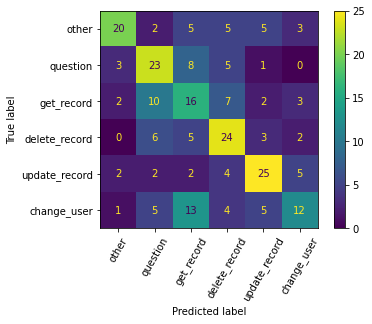

In [24]:
#SVM, Naive Bayes, Log reg, random forest 

from sklearn.tree import DecisionTreeClassifier


params = {
    #compare both split evaluation functions
    'criterion' : ['gini', 'entropy'], 
    
    #after some research it's was found a tree in this depth range is approate for a database of this size 
    'max_depth' : [9, 12, 15, 19], 
    
    #this describes what % of each class should be at each leaf node, a higher value here can be used to limit overfitting
    'min_weight_fraction_leaf' : [0.0, 0.1, 0.2, 0.3], 
    
    #this decides if a split is allowed based on how many samples are at that node
    'min_samples_split' : [2, 3, 4, 5, 6, 7, 8, 9, 10]
}


gs_decision_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    scoring='accuracy',
    cv=5
    )


gs_decision_tree.fit(mean_train_x,train_y)

print(gs_decision_tree.best_params_)

pred = gs_decision_tree.predict(mean_test_x)

print(f'accuracy score {accuracy_score(test_y, pred)}')
print(f'balanced accuracy score {balanced_accuracy_score(test_y, pred)}')
print(f'precision {precision_score(test_y, pred,average=None)}')
print(f'recall {recall_score(test_y, pred, average=None)}')


cm = confusion_matrix(test_y, pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels.unique())
cm_display.plot(xticks_rotation=60)


{'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0}
accuracy score 0.8291666666666667
balanced accuracy score 0.8291666666666666
precision [1.         0.94594595 0.81578947 0.69642857 0.80487805 0.79411765]
recall [0.85  0.875 0.775 0.975 0.825 0.675]


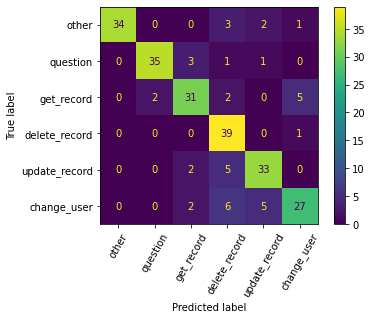

In [25]:

params = {
    #compare both split evaluation functions
    'criterion' : ['gini', 'entropy'], 
    
    #after some research it's was found a tree in this depth range is approate for a database of this size 
    'max_depth' : [9, 12, 15, 19], 
    
    #this describes what % of each class should be at each leaf node, a higher value here can be used to limit overfitting
    'min_weight_fraction_leaf' : [0.0, 0.1, 0.2, 0.3], 
    
    #this decides if a split is allowed based on how many samples are at that node
    'min_samples_split' : [2, 3, 4, 5, 6, 7, 8, 9, 10]
}


gs_decision_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    scoring='accuracy',
    cv=5
    )


gs_decision_tree.fit(bow_train_x,train_y)

print(gs_decision_tree.best_params_)

pred = gs_decision_tree.predict(bow_test_x)

print(f'accuracy score {accuracy_score(test_y, pred)}')
print(f'balanced accuracy score {balanced_accuracy_score(test_y, pred)}')
print(f'precision {precision_score(test_y, pred,average=None)}')
print(f'recall {recall_score(test_y, pred, average=None)}')


cm = confusion_matrix(test_y, pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels.unique())
cm_display.plot(xticks_rotation=60)

## Naive Bayes test


accuracy score 0.6125
balanced accuracy score 0.6125
precision [0.725      0.6097561  0.44897959 0.64285714 0.62222222 0.69565217]
recall [0.725 0.625 0.55  0.675 0.7   0.4  ]


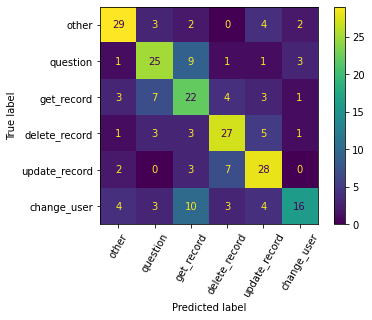

In [26]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB


naive_bayes = GaussianNB()
naive_bayes.fit(mean_train_x , train_y)

pred = naive_bayes.predict(mean_test_x)

print(f'accuracy score {accuracy_score(test_y, pred)}')
print(f'balanced accuracy score {balanced_accuracy_score(test_y, pred)}')
print(f'precision {precision_score(test_y, pred,average=None)}')
print(f'recall {recall_score(test_y, pred, average=None)}')


cm = confusion_matrix(test_y, pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels.unique())
cm_display.plot(xticks_rotation=60)

accuracy score 0.9291666666666667
balanced accuracy score 0.9291666666666667
precision [0.97560976 0.93023256 0.97297297 0.93939394 0.84444444 0.92682927]
recall [1.    1.    0.9   0.775 0.95  0.95 ]


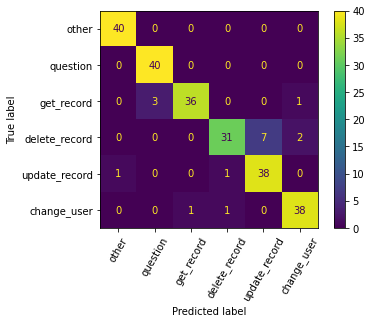

In [27]:
naive_bayes = MultinomialNB()
naive_bayes.fit(bow_train_x , train_y)

pred = naive_bayes.predict(bow_test_x)

print(f'accuracy score {accuracy_score(test_y, pred)}')
print(f'balanced accuracy score {balanced_accuracy_score(test_y, pred)}')
print(f'precision {precision_score(test_y, pred,average=None)}')
print(f'recall {recall_score(test_y, pred, average=None)}')


cm = confusion_matrix(test_y, pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels.unique())
cm_display.plot(xticks_rotation=60)

## log regession 

/home/michael/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/michael/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/michael/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The m

accuracy score 0.825
balanced accuracy score 0.8250000000000001
precision [0.88095238 0.82926829 0.70731707 0.81395349 0.85714286 0.87096774]
recall [0.925 0.85  0.725 0.875 0.9   0.675]


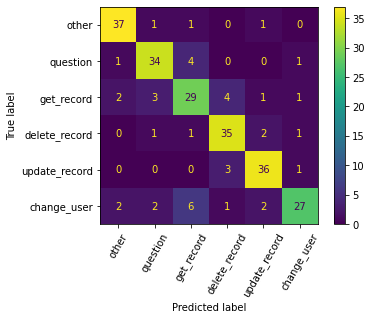

In [28]:
from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression()

param_grid = [{
    
    #considers each penalty type
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    
    #considers each solver type
    'solver' : ['lbfgs','liblinear','sag','saga'],
    
    #Inverse of regularisation strength. logspace consdiers primarily lower values. 
    'C' : np.logspace(-1, 1, 10),
    
    #given a dataset of this size, few iterations are needed: 1000 is overkill
    'max_iter' : [20, 50, 100]
}]

clf = GridSearchCV(log_reg, 
        param_grid = param_grid, 
        cv = 5, #cross validation splitting strategy. 
        n_jobs=-1)

clf.fit(mean_train_x,train_y)

pred = clf.predict(mean_test_x)

print(f'accuracy score {accuracy_score(test_y, pred)}')
print(f'balanced accuracy score {balanced_accuracy_score(test_y, pred)}')
print(f'precision {precision_score(test_y, pred,average=None)}')
print(f'recall {recall_score(test_y, pred, average=None)}')


cm = confusion_matrix(test_y, pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels.unique())
cm_display.plot(xticks_rotation=60)

/home/michael/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

accuracy score 0.9541666666666667
balanced accuracy score 0.9541666666666666
precision [0.97560976 0.95238095 0.92307692 0.92682927 1.         0.95      ]
recall [1.    1.    0.9   0.95  0.925 0.95 ]


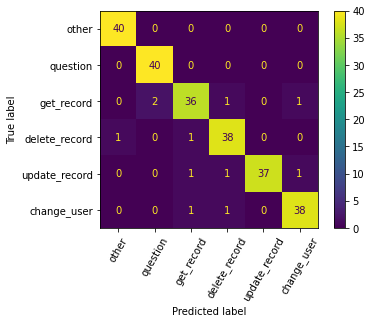

In [29]:
from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression()

param_grid = [{
    
    #considers each penalty type
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    
    #considers each solver type
    'solver' : ['lbfgs','liblinear','sag','saga'],
    
    #Inverse of regularisation strength. logspace consdiers primarily lower values. 
    'C' : np.logspace(-1, 1, 10),
    
    #given a dataset of this size, few iterations are needed: 1000 is overkill
    'max_iter' : [20, 50, 100]
}]

clf = GridSearchCV(log_reg, 
        param_grid = param_grid, 
        cv = 5, #cross validation splitting strategy. 
        n_jobs=-1)

clf.fit(bow_train_x,train_y)

pred = clf.predict(bow_test_x)

print(f'accuracy score {accuracy_score(test_y, pred)}')
print(f'balanced accuracy score {balanced_accuracy_score(test_y, pred)}')
print(f'precision {precision_score(test_y, pred,average=None)}')
print(f'recall {recall_score(test_y, pred, average=None)}')


cm = confusion_matrix(test_y, pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels.unique())
cm_display.plot(xticks_rotation=60)

## SVM

accuracy score 0.8875
balanced accuracy score 0.8875000000000001
precision [0.925      0.7826087  0.83333333 0.97435897 0.91891892 0.91666667]
recall [0.925 0.9   0.875 0.95  0.85  0.825]


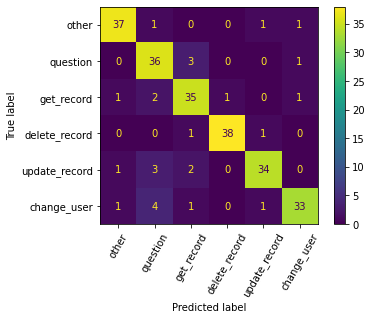

In [30]:
from sklearn.svm import SVC

params = [
   {'kernel' : ['rbf'], 'C' : [0.01, 0.1, 1, 10, 100], 'gamma' : [0.01, 0.1, 1, 10]},
   { 'kernel' : ['poly'], 'C' : [0.01, 0.1, 1, 10, 100], 'degree' : [1, 2, 3, 4, 5]}
]


gs_svm = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    scoring='accuracy',
    cv=5
    )

gs_svm.fit(mean_train_x, train_y)

pred = gs_svm.predict(mean_test_x)

print(f'accuracy score {accuracy_score(test_y, pred)}')
print(f'balanced accuracy score {balanced_accuracy_score(test_y, pred)}')
print(f'precision {precision_score(test_y, pred,average=None)}')
print(f'recall {recall_score(test_y, pred, average=None)}')


cm = confusion_matrix(test_y, pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels.unique())
cm_display.plot(xticks_rotation=60)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
accuracy score 0.9541666666666667
balanced accuracy score 0.9541666666666667
precision [1.         1.         0.92105263 0.93023256 0.97435897 0.9047619 ]
recall [0.975 0.975 0.875 1.    0.95  0.95 ]


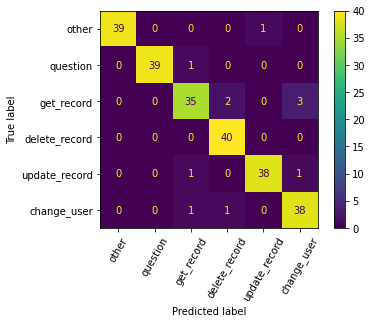

In [31]:
from sklearn.svm import SVC

params = [
   {'kernel' : ['rbf'], 'C' : [0.01, 0.1, 1, 10, 100], 'gamma' : [0.01, 0.1, 1, 10]},
   { 'kernel' : ['poly'], 'C' : [0.01, 0.1, 1, 10, 100], 'degree' : [1, 2, 3, 4, 5]}
]


gs_svm = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    scoring='accuracy',
    cv=5
    )

gs_svm.fit(bow_train_x, train_y)
print(gs_svm.best_params_)
pred = gs_svm.predict(bow_test_x)

print(f'accuracy score {accuracy_score(test_y, pred)}')
print(f'balanced accuracy score {balanced_accuracy_score(test_y, pred)}')
print(f'precision {precision_score(test_y, pred,average=None)}')
print(f'recall {recall_score(test_y, pred, average=None)}')

with open('intent_classifier.pkl', 'wb') as f:
    pickle.dump(gs_svm, f)

cm = confusion_matrix(test_y, pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels.unique())
cm_display.plot(xticks_rotation=60)

## MLP


/home/michael/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michael/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michael/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michael/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michael/.local/lib/python3.10/site-pac

accuracy score 0.8416666666666667
balanced accuracy score 0.8416666666666667
precision [0.84090909 0.85       0.73170732 0.88095238 0.90243902 0.84375   ]
recall [0.925 0.85  0.75  0.925 0.925 0.675]


/home/michael/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


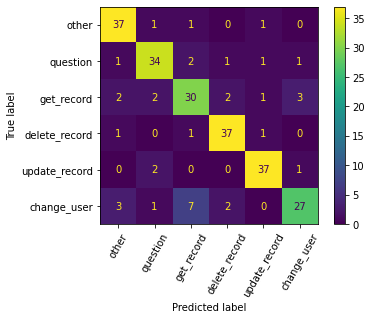

In [32]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=150)

param_grid = {
    'hidden_layer_sizes':[(32,), (64,), (64, 32), (50,), (100,), (100, 50),],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
}

mlp_grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=5, n_jobs=-1)

mlp_grid_search.fit(mean_train_x, train_y)

pred = mlp_grid_search.predict(mean_test_x)

print(f'accuracy score {accuracy_score(test_y, pred)}')
print(f'balanced accuracy score {balanced_accuracy_score(test_y, pred)}')
print(f'precision {precision_score(test_y, pred,average=None)}')
print(f'recall {recall_score(test_y, pred, average=None)}')


cm = confusion_matrix(test_y, pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels.unique())
cm_display.plot(xticks_rotation=60)

/home/michael/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michael/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michael/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michael/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/michael/.local/lib/python3.10/site-pac

accuracy score 0.9375
balanced accuracy score 0.9375
precision [0.97560976 0.95121951 0.90243902 1.         0.88636364 0.92857143]
recall [1.    0.975 0.925 0.775 0.975 0.975]


/home/michael/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


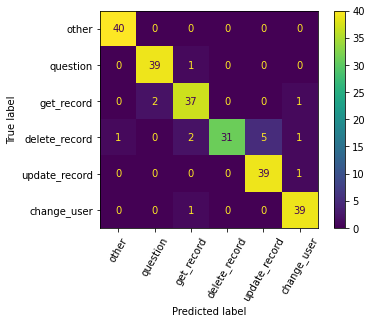

In [33]:
mlp = MLPClassifier(max_iter=150)

param_grid = {
    'hidden_layer_sizes':[(32,), (64,), (64, 32), (50,), (100,), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
}

mlp_grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=5, n_jobs=-1)

mlp_grid_search.fit(bow_train_x, train_y)

pred = mlp_grid_search.predict(bow_test_x)

print(f'accuracy score {accuracy_score(test_y, pred)}')
print(f'balanced accuracy score {balanced_accuracy_score(test_y, pred)}')
print(f'precision {precision_score(test_y, pred,average=None)}')
print(f'recall {recall_score(test_y, pred, average=None)}')


cm = confusion_matrix(test_y, pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels.unique())
cm_display.plot(xticks_rotation=60)